## Projeto 2
*Thiago Laidler Vidal Cunha*
DRE: 118030531

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import math
import scipy.stats as stats
from tqdm import tqdm 
import time
import multiprocessing as mp
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import curve_fit
#import latexify
import random
import scipy.special as sp
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import butter, freqz, filtfilt

**1)** Bruno fez  uma  observação  e  obteve  os  dados  apresentado  nos  arquivos  alvo_1.dat, alvo_2.dat  e alvo_3.dat,  onde  constam  a  posição  do  pixel  de  um  corte  vertical  da  PSF (coluna  1),  e  o  número  de  contagens  sob  o  CCD  (coluna  2).  Com  estes  dados  ele  está interessado em determinar os parâmetros da PSF das estrelas observadas.
**Obs.:** Monte suas próprias funções para ajustar esses dados (**não** usar curve_fit ou similares)

    (a) Ajuste uma função gaussiana aos dados e determine a amplitude máxima dos alvos (β1). Qual a estrela mais brilhante (maior β1)? Faça isso usando mínimos quadrados e a técnica de minimização de sua escolha. (2 pt) 

# $ f(x) = \beta_0 + \beta_{1}* e^{\frac{-(x - \beta_2)^{2}}{2* \beta_{3}^{2}}} $

    (b) Calcule as incertezas desses parâmetros e monte as matrizes de covariância e variância para cada ajuste. Qual destes objetos possui a melhor qualidade (menores variâncias)? (2 pt)

    (c) Uma das estrelas aparentemente possui uma baixa qualidade, Bruno está se perguntando qual a chance dela ser apenas ruído e não representar uma detecção real dentro de um limite de 99.7% de certeza. Calcule a probabilidade dessa detecção ser uma Falsa Positiva. (1 pt) 

    (d) Em uma tentativa de melhorar a qualidade das imagens Bruno decidiu buscar maneiras de diminuir o ruído. Aplique filtros digitais na tentativa de enfatizar o sinal das estrelas. (1 pt) 

    (e) Aplique a função de ajuste já preparada aos dados após a aplicação dos filtros digitais. Compare as incertezas obtidas com aquelas determinadas antes dos filtros digitais. (1 pt) 

In [2]:
alvo_1 = pd.read_csv('alvo_1.dat', delim_whitespace=True)
df_1 = pd.DataFrame(data = alvo_1.values, columns = ['Pixel', 'Valor'])
alvo_2 = pd.read_csv('alvo_2.dat', delim_whitespace=True)
df_2 = pd.DataFrame(data = alvo_2.values, columns = ['Pixel', 'Valor'])
alvo_3 = pd.read_csv('alvo_3.dat', delim_whitespace=True)
df_3 = pd.DataFrame(data = alvo_3.values, columns = ['Pixel', 'Valor'])

In [3]:
df_1.describe()

,Pixel,Valor
count,49.00000,49.000000
mean,25.00000,427.030003
std,14.28869,205.643924
min,1.00000,168.910192
25%,13.00000,296.473188
50%,25.00000,367.783776
75%,37.00000,508.362095
max,49.00000,936.018495


In [4]:
df_2.describe()

,Pixel,Valor
count,49.00000,49.000000
mean,25.00000,145.392357
std,14.28869,117.591070
min,1.00000,-91.090135
25%,13.00000,56.959802
50%,25.00000,146.690581
75%,37.00000,220.777362
max,49.00000,440.563706


In [5]:
df_3.describe()

,Pixel,Valor
count,49.00000,49.000000
mean,25.00000,74.279506
std,14.28869,78.153362
min,1.00000,-38.718687
25%,13.00000,6.131651
50%,25.00000,63.283975
75%,37.00000,128.308095
max,49.00000,232.478933


 Usando o primeiro alvo como exemplo, mostro como funcionará a modelagem dos nosso dados:

In [6]:
def func(x,b0,b1,b2,b3):
    '''
    Função que retorna a Gaussiana para o ajuste
    '''
    return b0 + b1 * np.exp((-(x - b2)**2)/(2*b3**2))

In [7]:
## Começando pela análise do primeiro alvo
x = df_1['Pixel']
y = df_1['Valor']

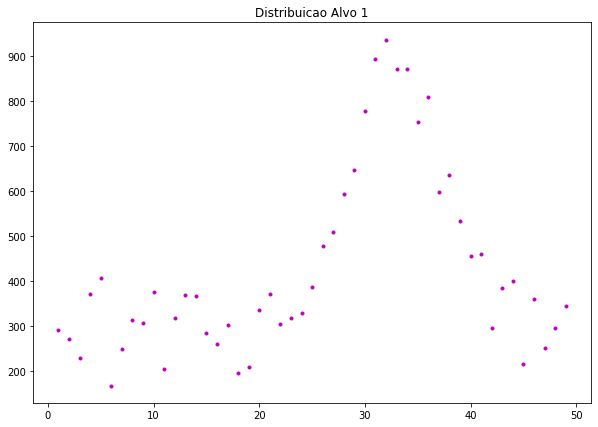

In [8]:
plt.figure(figsize = [10,7])
plt.title('Distribuicao Alvo 1')
plt.plot(x, y,'m.')
plt.show()

In [9]:
#Chutes iniciais :
beta_0_init = 280.0
beta_1_init = 600.0
beta_2_init = 30
beta_3_init = -3

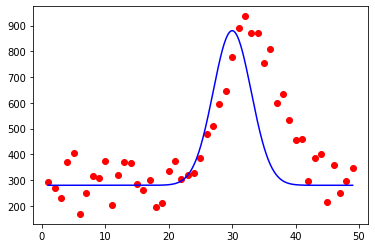

In [10]:
beta_0 = beta_0_init
beta_1 = beta_1_init
beta_2 = beta_2_init
beta_3 = beta_3_init

x_new = np.linspace(x.min(), x.max(), 1000)
    
plt.plot(x, y, 'ro')
plt.plot(x_new, func(x_new, beta_0, beta_1, beta_2, beta_3) , 'b-')
plt.show()


Temos que, a partir dos nossos resíduos, podemos explorar o método de Gauss-Newton (já que se trata de um ajuste não linear) da seguinte forma:


# $r_i = y_i - (\beta_0 + \beta_{1}* e^{\frac{-(x - \beta_2)^{2}}{2* \beta_{3}^{2}}})$
Podemos calcular nossa matriz jacobiana, e seus elementos serão:

# $\frac{\partial r_i}{\partial \beta_0} = -1 $

# $\frac{\partial r_i}{\partial \beta_1} = - e^{\frac{-(x - \beta_2)^{2}}{2* \beta_{3}^{2}}} $

# $\frac{\partial r_i}{\partial \beta_2} = - \beta_1 * e^{\frac{-(x - \beta_2)^{2}}{2* \beta_{3}^{2}}} * \frac{(x - \beta_2)}{\beta_{3}^{2}}$

# $\frac{\partial r_i}{\partial \beta_3} = - \beta_1 * e^{\frac{-(x - \beta_2)^{2}}{2* \beta_{3}^{2}}} * (x - \beta_2)^{2} *\frac{1}{\beta_{3}^{3}}$

In [11]:
res = y - func(x, beta_0, beta_1, beta_2, beta_3)

jacob_matrix = np.zeros([len(x), 4])

In [12]:
for i in range(len(x)):
    jacob_matrix[i, 0] = -1
    jacob_matrix[i, 1] = -np.exp((-(x[i] - beta_2)**2)/(2*beta_3**2))
    jacob_matrix[i, 2] = -beta_1*np.exp((-(x[i] - beta_2)**2)/(2*beta_3**2))*(x[i] - beta_2)/(beta_3**2)
    jacob_matrix[i, 3] = -beta_1*np.exp((-(x[i] - beta_2)**2)/(2*beta_3**2))*((x[i] - beta_2)**2)/(beta_3**3)

In [13]:
delta = np.matmul(
    np.matmul(
        np.linalg.inv(
            np.matmul(jacob_matrix.T, jacob_matrix)), jacob_matrix.T), res)

print(delta)

[-41.28884086 171.03566068  -1.97947601   1.30025563]


In [14]:
beta_0 = beta_0 - delta[0]
beta_1 = beta_1 - delta[1]
beta_2 = beta_2 - delta[2]
beta_3 = beta_3 - delta[3]

print(beta_0, beta_1,beta_2, beta_3)

321.28884085664123 428.9643393157496 31.97947601256095 -4.300255625771848


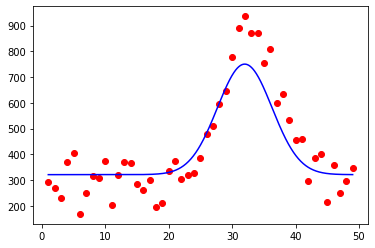

In [15]:
plt.plot(x, y, 'ro')
plt.plot(x_new, func(x_new, beta_0, beta_1, beta_2, beta_3) , 'b-')
plt.show()

Agora basta refazermos este processo até conseguirmos o ajuste desejado. Criei uma função que torna isso possível, de forma que o loop para apenas com um novo desvio padrão que seja diferente em menos de 1%. Também criei uma função que calcule a soma dos residuos quadrados de cada ajuste a fim de termos uma ideia mais concreta de qual ajuste ficou mais preciso.

In [16]:
def funcao_ajuste(x,y, beta_0,beta_1,beta_2,beta_3):
    '''Ajuste seguindo a funcao de interesse. Essa função fará, basicamente, o que fizemos anteriormente
    mas em loop. Criterio de convergência, novo desvio padrão diferente em menos de 1%'''
    x_new = np.linspace(x.min(), x.max(), 1000)
    res = y - func(x, beta_0, beta_1, beta_2, beta_3)
    df_r = pd.Series(res)
    jacob_matrix = np.zeros([len(x), 4])
    for i in range(len(x)):
        jacob_matrix[i, 0] = -1
        jacob_matrix[i, 1] = -np.exp((-(x[i] - beta_2)**2)/(2*beta_3**2))
        jacob_matrix[i, 2] = -beta_1*np.exp((-(x[i] - beta_2)**2)/(2*beta_3**2))*(x[i] - beta_2)/(beta_3**2)
        jacob_matrix[i, 3] = -beta_1*np.exp((-(x[i] - beta_2)**2)/(2*beta_3**2))*((x[i] - beta_2)**2)/(beta_3**3)
    
    delta = np.matmul(np.matmul(np.linalg.inv(np.matmul(jacob_matrix.T, jacob_matrix)), jacob_matrix.T), res)
    ##Primeira tentativa
    while(True):
        beta_0 = beta_0 - delta[0]
        beta_1 = beta_1 - delta[1]
        beta_2 = beta_2 - delta[2]
        beta_3 = beta_3 - delta[3]
        res_new = y - func(x, beta_0, beta_1, beta_2, beta_3)
        df_rnew = pd.Series(res)
        if (abs(df_r.std() - df_rnew.std())) < 0.01*df_r.std(): #Se a diferença entre desvios do residuo novo e antigo for menor que 1% do antigo
            break
        else:
            res = res_new
            df_r = pd.Series(res)
            for i in range(len(x)):
                jacob_matrix[i, 0] = -1
                jacob_matrix[i, 1] = -np.exp((-(x[i] - beta_2)**2)/(2*beta_3**2))
                jacob_matrix[i, 2] = -beta_1*np.exp((-(x[i] - beta_2)**2)/(2*beta_3**2))*(x[i] - beta_2)/(beta_3**2)
                jacob_matrix[i, 3] = -beta_1*np.exp((-(x[i] - beta_2)**2)/(2*beta_3**2))*((x[i] - beta_2)**2)/(beta_3**3)
            delta = np.matmul(np.matmul(np.linalg.inv(np.matmul(jacob_matrix.T, jacob_matrix)), jacob_matrix.T), res)
    return beta_0,beta_1,beta_2,beta_3

def residuo_quadrado(data, modelo):
    return np.sum((data - modelo)**2)

In [17]:
def matrix_var_cov(parametros):
    '''
    Criação da matriz covariancia e variancia dos parametros. 
    Recebe uma matriz 4x4 em que cada linha é uma array 
    com todos os valores possiveis do parametro especifico. 
    Retorna a matriz 4x4 de variancia e covariancia entre os parametros.
    '''
    matrix = np.zeros([4, 4])
    for i in range(4):
            matrix[i, 0] = np.sum((parametros[0] - parametros[0].mean())*(parametros[i] - parametros[i].mean()))/(len(parametros[0])-1)
            matrix[i, 1] = np.sum((parametros[1] - parametros[1].mean())*(parametros[i] - parametros[i].mean()))/(len(parametros[1])-1)
            matrix[i, 2] = np.sum((parametros[2] - parametros[2].mean())*(parametros[i] - parametros[i].mean()))/(len(parametros[2])-1)
            matrix[i, 3] = np.sum((parametros[3] - parametros[3].mean())*(parametros[i] - parametros[i].mean()))/(len(parametros[3])-1)
    return matrix        

**Agora calculemos os valores de $\beta$ para cada alvo:**

### Alvo 1:

In [18]:
parameters = funcao_ajuste(x,y, beta_0,beta_1,beta_2,beta_3)
parameters

(297.86612836473347, 586.5472822744737, 33.327967159420304, -4.306612352149425)

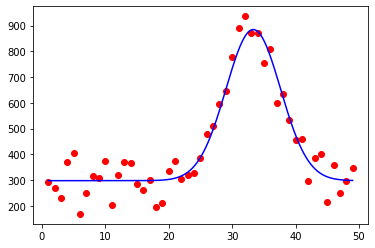

In [19]:
plt.plot(x, y, 'ro')
plt.plot(x_new, func(x_new, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.show()

$\beta_0 = 296.0036$ ; $\beta_1 = 598.497$ ; $\beta_2 = 32.950$; $\beta_3 = -4.27949 $.

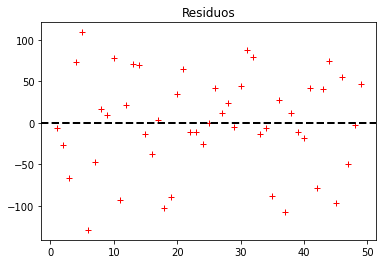

Soma dos quadrados dos residuos: 164647.35849792068


In [20]:
plt.title('Residuos')
plt.plot(x, y - func(x, parameters[0], parameters[1], parameters[2], parameters[3]) , 'r+')
plt.axhline(0, color='k', ls='--', lw=2)
plt.show()

print('Soma dos quadrados dos residuos:', residuo_quadrado(data=y, modelo=
                                                           func(x, parameters[0], parameters[1], 
                                                                parameters[2], parameters[3])))

### Método Bootstrap
Definindo os intervalos de confiança para $\beta$.

In [21]:
indices = np.arange(len(x))
np.random.shuffle(indices)
mask = np.append(indices[0:37], indices[0:12])
x2 = np.array(x[mask])
y2 = np.array(y[mask])

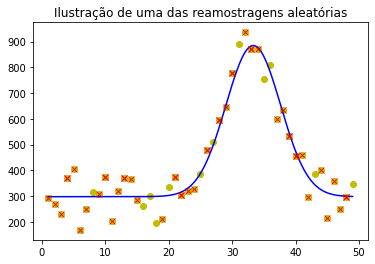

In [22]:
plt.title('Ilustração de uma das reamostragens aleatórias')
plt.plot(x, y, 'yo')
plt.plot(x_new, func(x_new, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.plot(x2,y2,'rx',alpha = 0.9)
plt.show()

In [23]:
indices = np.arange(len(x))
b0 = np.array([])
b1 = np.array([])
b2 = np.array([])
b3 = np.array([])

'''
        Ajustando cada reamostragem e guardando os parametros.
'''

for loop in range(1000): #Junção de 1000 elementos de valores beta relativos a cada reamostragem
    np.random.shuffle(indices)
    mask = np.append(indices[0:37], indices[0:12])
    x2 = np.array(x[mask])
    y2 = np.array(y[mask])
    parm = funcao_ajuste(x2,y2, parameters[0],parameters[1], parameters[2], parameters[3])
    b0 = np.append(b0,parm[0])
    b1 = np.append(b1,parm[1])
    b2 = np.append(b2,parm[2])
    b3 = np.append(b3,parm[3])

In [24]:
dfb0 = pd.Series(b0)
dfb1 = pd.Series(b1)
dfb2 = pd.Series(b2)
dfb3 = pd.Series(b3)

B0: 295.3301249997213+/-26.628876835415284


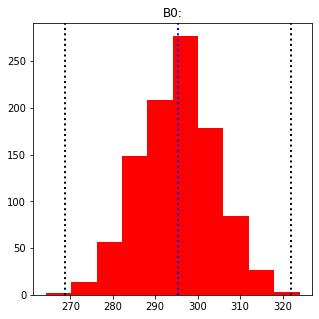

In [25]:
plt.figure(figsize = [5,5])
plt.title('B0:')
plt.hist(b0,bins=10,color='r')
plt.axvline(dfb0.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb0.std()*3 + dfb0.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb0.std()*3 + dfb0.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B0: '+str(dfb0.mean())+'+/-'+str(3*dfb0.std()))
plt.show()

B1: 595.0609602944229+/-56.71138225967997


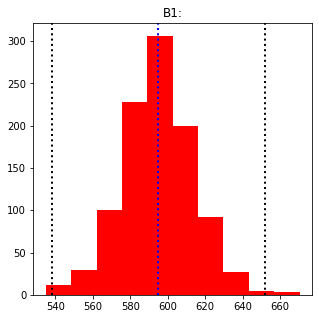

In [26]:
plt.figure(figsize = [5,5])
plt.title('B1:')
plt.hist(b1,bins=10,color='r')
plt.axvline(dfb1.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb1.std()*3 + dfb1.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb1.std()*3 + dfb1.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B1: '+str(dfb1.mean())+'+/-'+str(3*dfb1.std()))
plt.show()

B2: 32.94308467841348+/-0.3823638629294206


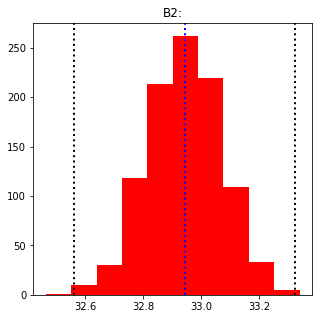

In [27]:
plt.figure(figsize = [5,5])
plt.title('B2:')
plt.hist(b2,bins=10,color='r')
plt.axvline(dfb2.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb2.std()*3 + dfb2.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb2.std()*3 + dfb2.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B2: '+str(dfb2.mean())+'+/-'+str(3*dfb2.std()))
plt.show()

B3: -4.32989246518418+/-0.41075539172494413


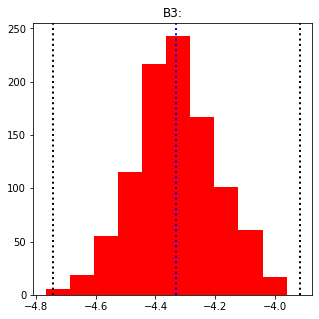

In [28]:
plt.figure(figsize = [5,5])
plt.title('B3:')
plt.hist(b3,bins=10,color='r')
plt.axvline(dfb3.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb3.std()*3 + dfb3.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb3.std()*3 + dfb3.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B3: '+str(dfb3.mean())+'+/-'+str(3*dfb3.std()))
plt.show()

$\beta_0 = 295.08 \pm 25.95$ ; $\beta_1 = 594.92 \pm 53.56$ ; $\beta_2 = 32.94 \pm 0.40$; $\beta_3 = -4.33 \pm 0.43$

In [29]:
parm = b0,b1,b2,b3
print('Matriz das variancias e covariancias entre os parâmetros.')
pd.DataFrame(matrix_var_cov(parm),columns=['Beta0','Beta1','Beta2','Beta3'])

Matriz das variancias e covariancias entre os parâmetros.


,Beta0,Beta1,Beta2,Beta3
0,78.788565,-66.771434,0.039366,0.663868
1,-66.771434,357.353431,0.321679,0.599110
2,0.039366,0.321679,0.016245,-0.003283
3,0.663868,0.599110,-0.003283,0.018747


In [30]:
#Conferindo com pandas:
print(np.sqrt(matrix_var_cov(parm)[0][0]),dfb0.std(),'\n')
print(np.sqrt(matrix_var_cov(parm)[1][1]),dfb1.std())

8.876292278471757 8.87629227847176 

18.90379408655999 18.90379408655999


In [31]:
y_modelo = func(x, parameters[0], parameters[1], parameters[2], parameters[3])
residuo = pd.Series(y - y_modelo)
residuo.describe()

count     49.000000
mean      -0.046174
std       58.567492
min     -128.955937
25%      -26.745208
50%       -0.625266
75%       41.856275
max      108.989427
dtype: float64

#### Aplicar filtro
1) Encontrar a wavelet que mais se encaixa 

ou

2) Ir por transformada de fourier:
    

### 1)

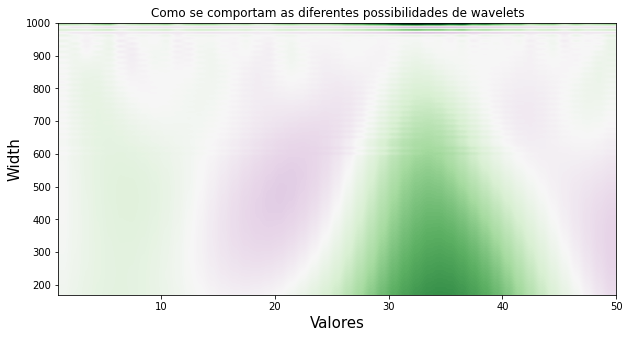

In [32]:
#Continuous wavelet transform. Vai transformar seguindo uma função de wavelets.
#Ricker wavelet, é o " Chapéu Mexicano" , signal.morlet2 é a onda em forma de sanduiche
widths = np.arange(0.1,10,0.1)
cwtmatr = signal.cwt(y, signal.ricker, widths)

plt.figure(figsize = [10,5])
plt.title('Como se comportam as diferentes possibilidades de wavelets')
plt.imshow(cwtmatr, extent = [1,50,170,1000] #[xmin,xmax,ymin,ymax]
           , cmap='PRGn', aspect = 'auto', vmax = abs(cwtmatr).max(), 
           vmin = -abs(cwtmatr).max())
plt.ylabel('Width', fontsize = 15
          )
plt.xlabel('Valores' , fontsize = 15
          )
plt.show()

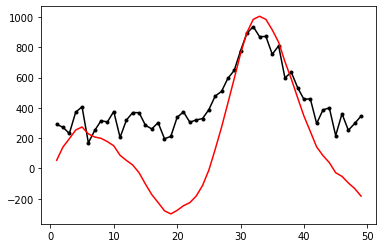

In [33]:
plt.plot(x, y, 'k.-')
plt.plot(x, cwtmatr.mean(axis=0), 'r-')

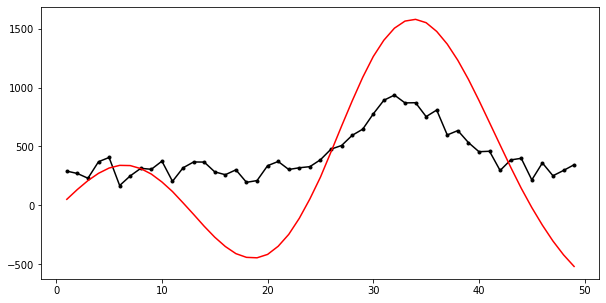

In [34]:
plt.figure(figsize = [10,5])
plt.plot(x,y, 'k.-')
plt.plot(x,cwtmatr[80],'r-')
plt.show()

#### Testando outra wavelet

50


/home/laidler/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


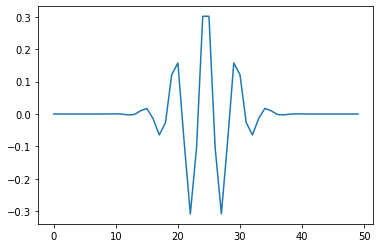

In [35]:
points = 50
a = 4.0
vec2 = signal.morlet2(points, a)
print(len(vec2))

plt.plot(vec2)
plt.show()

/home/laidler/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


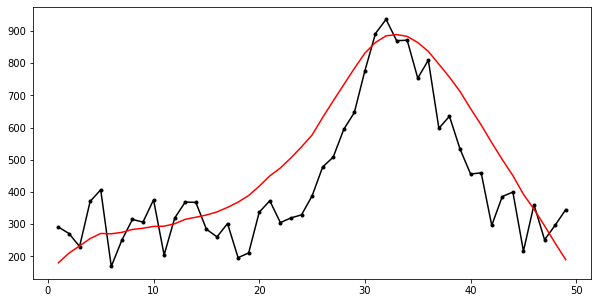

In [36]:
widths = np.arange(0.5,95 ,1.5)
cwtmatr = signal.cwt(y, signal.morlet2, widths)
plt.figure(figsize = [10,5])
plt.plot(x, y, 'k.-')
plt.plot(x, cwtmatr.mean(axis=0), 'r-')
plt.show()

### 2)

 - Tentativa de filtrar por Transformada de Fourier:

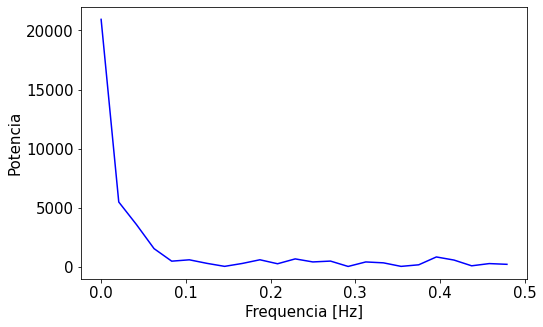

In [37]:
# Transformada de Fourier:
y = np.array(y)
x = np.array(x)

N = len(x) # Numero de pontos
T = (x[-1] - x[0])/len(x) # resolução dos pontos

# Aplicando a transformada de Fourier
yf = fft(y)[:int(N/2)]
xf = fftfreq(N, T)[:int(N/2)]

plt.figure(figsize=[8,5], facecolor='w')
plt.plot(xf, np.absolute(yf), color='blue')
plt.ylabel('Potencia', fontsize=15)
plt.xlabel('Frequencia [Hz]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [38]:
ordem = 10
corte = 0.1

filter_b, filter_a = butter(N=ordem, Wn=corte, fs=1/T, btype='lowpass')

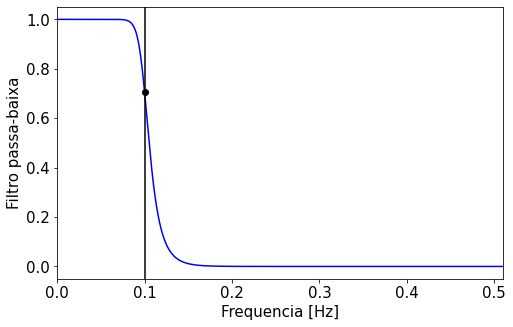

In [39]:
# Transformando o filtro em resposta de frequência
w, h = freqz(filter_b, filter_a, fs=1/T, worN=8000)

# Plot the frequency response.
plt.figure(figsize=[8,5], facecolor='w')
plt.plot(w, np.abs(h), 'b')
plt.plot(corte, 0.5*np.sqrt(2), 'ko')
plt.axvline(corte, color='k')
plt.xlim(0, 0.5*(1/T))
plt.ylabel("Filtro passa-baixa", fontsize=15)
plt.xlabel('Frequencia [Hz]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

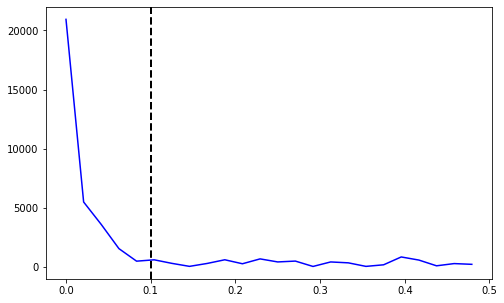

In [40]:
plt.figure(figsize=[8,5], facecolor='w')
plt.plot(xf, np.abs(yf),'b')
plt.axvline(corte, lw=2, ls='--', color='k')
plt.show()

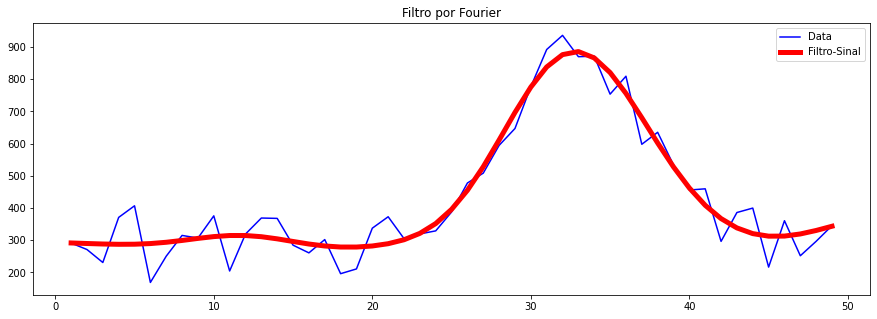

In [41]:
# Filter the data, and plot both the original and filtered signals.
#Após a filtragem dos dados, plot dos dados e do sinal filtrado.
y_filtro = filtfilt(filter_b, filter_a, y)

plt.figure(figsize=[15,5], facecolor='w')
plt.title('Filtro por Fourier')
plt.plot(x, y, 'b-', label='data')
plt.plot(x, y_filtro, 'r-', linewidth=5, label='filtered data')
plt.legend(['Data','Filtro-Sinal'])
plt.show()

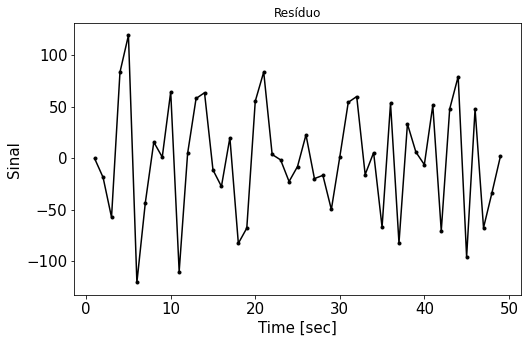

In [42]:
plt.figure(figsize=[8,5], facecolor='w')
plt.title('Resíduo')
plt.plot(x, y - y_filtro, 'k.-', label='data')
plt.xlabel('Time [sec]', fontsize=15)
plt.ylabel('Sinal', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

 - Reajustando os dados após a filtragem:

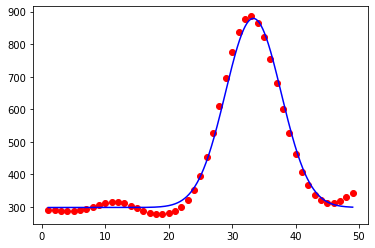

In [43]:
parameters = funcao_ajuste(x,y_filtro, beta_0,beta_1,beta_2,beta_3)

plt.plot(x, y_filtro, 'ro')
plt.plot(x_new, func(x_new, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.show()

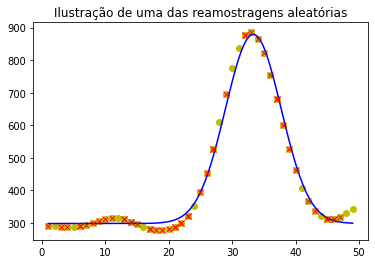

In [44]:
indices = np.arange(len(x))
np.random.shuffle(indices)
mask = np.append(indices[0:37], indices[0:12])
x2 = np.array(x[mask])
y2 = np.array(y_filtro[mask])

plt.title('Ilustração de uma das reamostragens aleatórias')
plt.plot(x, y_filtro, 'yo')
plt.plot(x_new, func(x_new, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.plot(x2,y2,'rx',alpha = 0.9)
plt.show()

In [45]:
indices = np.arange(len(x))
b0 = np.array([])
b1 = np.array([])
b2 = np.array([])
b3 = np.array([])

'''
        Ajustando cada reamostragem e guardando os parametros.
'''

for loop in range(1000): #Junção de 1000 elementos de valores beta relativos a cada reamostragem
    np.random.shuffle(indices)
    mask = np.append(indices[0:37], indices[0:12])
    x2 = np.array(x[mask])
    y2 = np.array(y_filtro[mask])
    parm = funcao_ajuste(x2,y2, parameters[0],parameters[1], parameters[2], parameters[3])
    b0 = np.append(b0,parm[0])
    b1 = np.append(b1,parm[1])
    b2 = np.append(b2,parm[2])
    b3 = np.append(b3,parm[3])


dfb0 = pd.Series(b0)
dfb1 = pd.Series(b1)
dfb2 = pd.Series(b2)
dfb3 = pd.Series(b3)

In [46]:
print('B0: '+str(dfb0.mean())+'+/-'+str(3*dfb0.std()))
print('B1: '+str(dfb1.mean())+'+/-'+str(3*dfb1.std()))
print('B2: '+str(dfb2.mean())+'+/-'+str(3*dfb2.std()))
print('B3: '+str(dfb3.mean())+'+/-'+str(3*dfb3.std()))

B0: 296.76208406787345+/-6.8902279712399075
B1: 591.2185266812289+/-9.677557821415828
B2: 32.96376120432779+/-0.06665860520068487
B3: -4.348040839720809+/-0.09138641644781331


**Comparado com:** 

$\beta_0 = 295.08 \pm 25.95$ ; $\beta_1 = 594.92 \pm 53.56$ ; $\beta_2 = 32.94 \pm 0.40$; $\beta_3 = -4.33 \pm 0.43$

Todas as incertezas caíram!

### Alvo 2:

In [47]:
x = df_2['Pixel']
y = df_2['Valor']

In [48]:
## Chutes iniciais
beta_0 = 102
beta_1 = 222
beta_2 = 28
beta_3 = -4

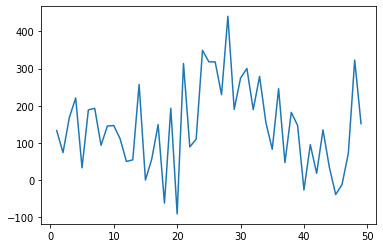

In [49]:
plt.plot(x,y)

In [50]:
parameters = funcao_ajuste(x,y, beta_0,beta_1,beta_2,beta_3)
parameters

(102.59071318426044,
 222.57155603263175,
 27.970684827144428,
 -3.758592947001587)

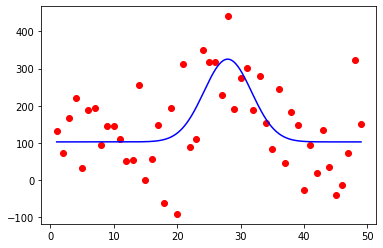

In [51]:
plt.plot(x, y, 'ro')
plt.plot(x_new, func(x_new, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.show()

$\beta_0 = 102.6$ ; $\beta_1 = 222.57$ ; $\beta_2 = 27.97$; $\beta_3 = -3.758 $.

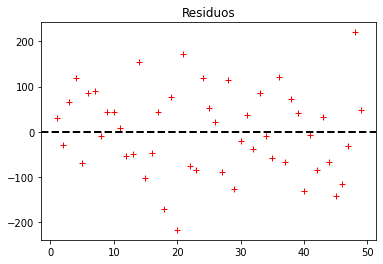

Soma dos quadrados dos residuos: 422664.78071193694


In [52]:
plt.title('Residuos')
plt.plot(x, y - func(x, parameters[0], parameters[1], parameters[2], parameters[3]) , 'r+')
plt.axhline(0, color='k', ls='--', lw=2)
plt.show()

print('Soma dos quadrados dos residuos:', residuo_quadrado(data=y, modelo=
                                                           func(x, parameters[0], parameters[1], 
                                                                parameters[2], parameters[3])))

### Método Bootstrap
Definindo os intervalos de confiança para $\beta$.

In [53]:
indices = np.arange(len(x))
np.random.shuffle(indices)
mask = np.append(indices[0:37], indices[0:12])
x2 = np.array(x[mask])
y2 = np.array(y[mask])

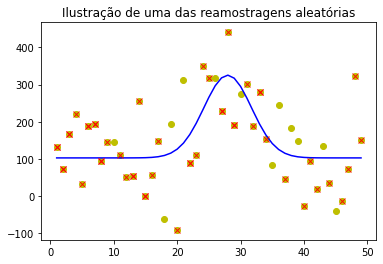

In [54]:
plt.title('Ilustração de uma das reamostragens aleatórias')
plt.plot(x, y, 'yo')
plt.plot(x, func(x, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.plot(x2,y2,'rx',alpha = 0.9)
plt.show()

In [55]:
indices = np.arange(len(x))
b0 = np.array([])
b1 = np.array([])
b2 = np.array([])
b3 = np.array([])

'''
        Ajustando cada reamostragem e guardando os parametros.
'''

for loop in range(1000): #Junção de 1000 elementos de valores beta relativos a cada reamostragem
    np.random.shuffle(indices)
    mask = np.append(indices[0:37], indices[0:12])
    x2 = np.array(x[mask])
    y2 = np.array(y[mask])
    parm = funcao_ajuste(x2,y2, parameters[0],parameters[1], parameters[2], parameters[3])
    b0 = np.append(b0,parm[0])
    b1 = np.append(b1,parm[1])
    b2 = np.append(b2,parm[2])
    b3 = np.append(b3,parm[3])

In [56]:
dfb0 = pd.Series(b0)
dfb1 = pd.Series(b1)
dfb2 = pd.Series(b2)
dfb3 = pd.Series(b3)

B0: 101.70179760352103+/-34.547801895992684


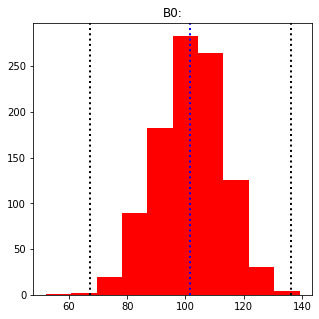

In [57]:
plt.figure(figsize = [5,5])
plt.title('B0:')
plt.hist(b0,bins=10,color='r')
plt.axvline(dfb0.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb0.std()*3 + dfb0.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb0.std()*3 + dfb0.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B0: '+str(dfb0.mean())+'+/-'+str(3*dfb0.std()))
plt.show()

B1: 223.34131736227332+/-110.68801389822363


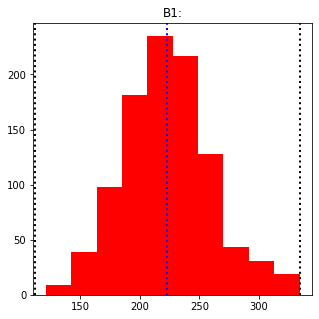

In [58]:
plt.figure(figsize = [5,5])
plt.title('B1:')
plt.hist(b1,bins=10,color='r')
plt.axvline(dfb1.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb1.std()*3 + dfb1.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb1.std()*3 + dfb1.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B1: '+str(dfb1.mean())+'+/-'+str(3*dfb1.std()))
plt.show()

B2: 27.908558906457415+/-1.7913554996231738


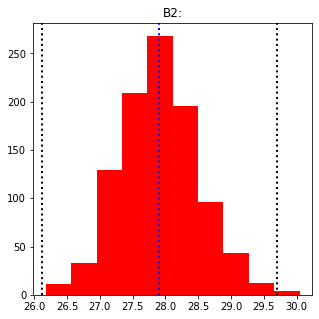

In [59]:
plt.figure(figsize = [5,5])
plt.title('B2:')
plt.hist(b2,bins=10,color='r')
plt.axvline(dfb2.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb2.std()*3 + dfb2.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb2.std()*3 + dfb2.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B2: '+str(dfb2.mean())+'+/-'+str(3*dfb2.std()))
plt.show()

B3: -3.8495312751037596+/-2.491179270724052


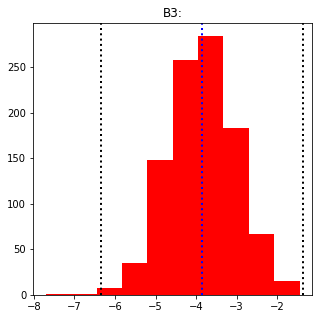

In [60]:
plt.figure(figsize = [5,5])
plt.title('B3:')
plt.hist(b3,bins=10,color='r')
plt.axvline(dfb3.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb3.std()*3 + dfb3.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb3.std()*3 + dfb3.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B3: '+str(dfb3.mean())+'+/-'+str(3*dfb3.std()))
plt.show()

$\beta_0 = 102.24 \pm 37.12$ ; $\beta_1 = 218.80 \pm 107.87$ ; $\beta_2 = 27.91 \pm 1.86$; $\beta_3 = -3.83 \pm 2.43$.

In [61]:
parm = b0,b1,b2,b3
print('Matriz das variancias e covariancias entre os parâmetros.')
pd.DataFrame(matrix_var_cov(parm),columns=['Beta0','Beta1','Beta2','Beta3'])

Matriz das variancias e covariancias entre os parâmetros.


,Beta0,Beta1,Beta2,Beta3
0,132.616735,-61.178948,0.343399,3.078904
1,-61.178948,1361.315158,3.859955,18.638869
2,0.343399,3.859955,0.356551,0.210423
3,3.078904,18.638869,0.210423,0.689553


In [62]:
y_modelo = func(x, parameters[0], parameters[1], parameters[2], parameters[3])
residuo = pd.Series(y - y_modelo)
residuo.describe()

count     49.000000
mean       0.007060
std       93.837712
min     -217.172768
25%      -68.023705
50%       -8.016959
75%       65.629725
max      220.136341
dtype: float64

Este é, claramente, o alvo com mais ruído. Vamos verificar a probabilidade de estarmos observando um sinal ou apenas ruido.

### Simulação:
A procura dos tipos de erros em detecções.

1. Erro do Tipo I:
O erro de rejeitar a hipótese nula, quando na verdade ela é verdadeira.
*Falso positivo*

2. Erro do Tipo II:
O erro de não rejeitar a hipótese nula, quando na verdade ela deveria ser rejeitada.
*Falso negativo*

Iremos simular dados com um ruído randômico com mesma dispersão dos dados reais e  ajustar  o  nosso modelo várias vezes.
Daí, teremos:

● **True Positive** (TP): Tem sinal e ele é detectado.

● **True Negative** (TN): *NÃO* tem sinal e ele *NÃO* é detectado.

● **False Negative** (FN): Tem sinal e ele *NÃO* é detectado.

● **False Positive** (FP): *NÃO* tem sinal, mas algo é detectado.

>Queremos achar a probabilidade de uma **Falsa Positiva** (FP)

 - Adicionando ruído no sinal:

In [63]:
y_modelo = func(x, parameters[0], parameters[1], parameters[2], parameters[3])
residuo = y - y_modelo

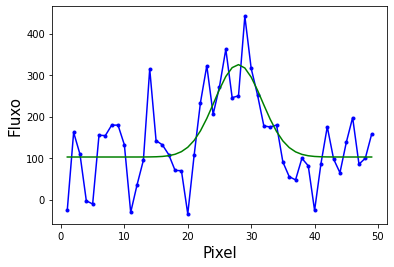

In [64]:
#Simulando

y2 = y_modelo + np.random.normal(0,residuo.std(),len(x))
#Pegando o y_modelo e adicionando ruidos normais

plt.plot(x, y2, 'b.-')
plt.plot(x, y_modelo, 'g-')
plt.ylabel('Fluxo', fontsize=15)
plt.xlabel('Pixel', fontsize=15)

plt.show()

In [ ]:
# Versão sem CURVE_FIT 
'''

       (Dá erro : unsupported operand type(s) for -: 'tuple' and 'tuple') em 
       "all(np.absolute(parameters2 - parameters) < 3*error):"

'''
#### Ajuste dos dados (basicamente o que foi feito até então)
parameters = funcao_ajuste(x,y, beta_0,beta_1,beta_2,beta_3)
parm = b0,b1,b2,b3 # parametros possiveis após bootstrap
covariance = matrix_var_cov(parm)

error = np.sqrt(np.diagonal(covariance))

### Ajuste da simulação (a mesma coisa, mas aplicado para y2)
parameters2 = funcao_ajuste(x,y2, beta_0,beta_1,beta_2,beta_3)
#Descobrir parm2 -> bootstrap em cima do ajuste em y2:
indices = np.arange(len(x))
b0_2 = np.array([])
b1_2 = np.array([])
b2_2 = np.array([])
b3_2 = np.array([])

for loop in range(1000): #Junção de 1000 elementos de valores beta relativos a cada reamostragem
    np.random.shuffle(indices)
    mask = np.append(indices[0:37], indices[0:12])
    x_2 = np.array(x[mask])
    y_2 = np.array(y2[mask])
    parm = funcao_ajuste(x_2,y_2, parameters[0],parameters[1], parameters[2], parameters[3])
    b0_2 = np.append(b0_2,parm[0])
    b1_2 = np.append(b1_2,parm[1])
    b2_2 = np.append(b2_2,parm[2])
    b3_2 = np.append(b3_2,parm[3])

parm2 = b0_2,b1_2,b2_2,b3_2
covariance2 = matrix_var_cov(parm2)

error2 = np.sqrt(np.diagonal(covariance2))

if all(np.absolute(parameters2 - parameters) < 3*error):#1*error -> 1sigma
    print('True Positive (3-sigma)') #Encontramos sinal esperado
else:
    print('False Negative (3-sigma)') #ja q acho algo, mas n encontro o sinal que deveria (encontramos sinal diferente)

In [66]:
##############Versão CURVE_FIT

beta_0 = beta_0_init
beta_1 = beta_1_init
beta_2 = beta_2_init
beta_3 = beta_3_init

parameters,covariance = curve_fit(func,x,y, p0=[beta_0, beta_1, beta_2, beta_3]) ##Ajuste dos dados
error = np.sqrt(np.diagonal(covariance))

parameters2,covariance2 = curve_fit(func,x,y2, p0=[beta_0, beta_1, beta_2, beta_3]) ##Ajuste da simulação
error2 = np.sqrt(np.diagonal(covariance2))

if all(np.absolute(parameters2 - parameters) < 3*error):#1*error -> 1sigma
    print('True Positive (3-sigma)') #Encontramos sinal esperado
else:
    print('False Negative (3-sigma)') #ja q acho algo, mas n encontro o sinal que deveria (encontramos sinal diferente)

True Positive (3-sigma)


In [67]:
#Cada vez que reproduzimos isso, podemos mudar o nosso resultado (criamos uma nova simulação). 
l = []
for loop in tqdm(range(1000)):
    try:
        y2 = y_modelo + np.random.normal(0,residuo.std(),len(x))
        parameters2,covariance2 = curve_fit(func,x,y2, p0=[beta_0, beta_1, beta_2, beta_3])
        error2 = np.sqrt(np.diagonal(covariance2)) #n vai ser util
        if all(np.absolute(parameters2 - parameters) < 3*error): #partindo do principio de que HÁ sinal
            l.append('T_P') #Positivo verdadeiro
        else:
            l.append('F_N') #Falso negativo
    except:
        pass

100%|██████████| 1000/1000 [02:16<00:00,  7.33it/s]


In [68]:
p_FN = list.count(l,'F_N') / len(l)
p_TP = list.count(l,'T_P') / len(l)

In [69]:
print('False Negative: '+str(p_FN*100)+'%\nTrue Positive: '+str(p_TP*100)+'%')

False Negative: 4.9%
True Positive: 95.1%


Falso Negativo = O sinal existe, mas não foi observado. Positivo Verdadeiro = Observou o sinal e ele existe.

Para calcular a probabilidade de ser **Falso Positivo**, teremos que fazer a simulação considerando apenas ruído:

- Simulação com *apenas* ruído

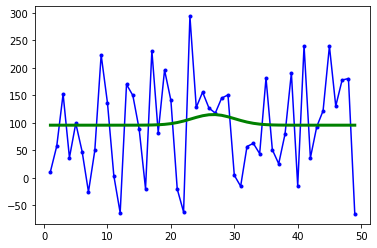

In [70]:
y3 = np.random.normal(dfb0.mean(),residuo.std(),len(x))
parameters3 = funcao_ajuste(x,y3, dfb0.mean(), dfb1.mean(), dfb2.mean(), dfb3.mean())
y_modelo3 = func(x, *parameters3)

plt.plot(x, y3, 'b.-')
plt.plot(x, y_modelo3, 'g-', lw=3)

plt.show()

In [71]:
#Criando simulação sem sinal (puramente ruido)
l2 = []
for loop in tqdm(range(1000)):
    try:
        y3 = np.random.normal(dfb0.mean(),residuo.std(),len(x))
        parameters3, covariance3 = curve_fit(func,x,y3,p0=[dfb0.mean(), dfb1.mean(), dfb2.mean(), dfb3.mean()])
    #    error3 = np.sqrt(np.diagonal(covariance3))
        if all(np.absolute(parameters3 - parameters) < 3*error): #partindo do principio de que não há sinal (3sigma)
            l2.append('F_P') #Positivo Falso
        else:
            l2.append('T_N') #Negativo verdadeiro
    except:
        pass

  0%|          | 0/1000 [00:00<?, ?it/s]/home/laidler/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]


In [72]:
p_FP = list.count(l2,'F_P') / len(l2)
p_TN = list.count(l2,'T_N') / len(l2)

print('False Positive: '+str(p_FP*100)+'%\nTrue Negative: '+str(p_TN*100)+'%')

False Positive: 6.733668341708543%
True Negative: 93.26633165829146%


**Ou seja, não havendo sinal, ele provavelmente não será detectado.  Se o sinal foi detectado, então há altas chances dele existir de fato.**

#### Filtrando os dados:

Mesmo método usado no **Alvo1**, por transformada de Fourier.

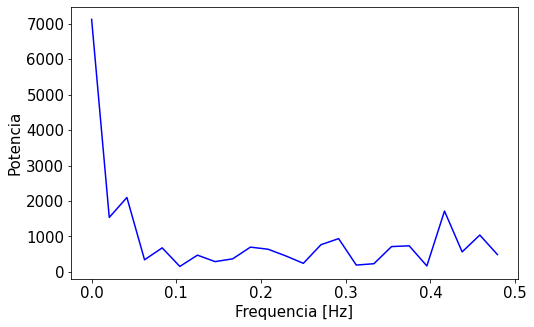

In [73]:
# Transformada de Fourier:
y = np.array(y)
x = np.array(x)

N = len(x) # Numero de pontos
T = (x[-1] - x[0])/len(x) # resolução dos pontos

# Aplicando a transformada de Fourier
yf = fft(y)[:int(N/2)]
xf = fftfreq(N, T)[:int(N/2)]

plt.figure(figsize=[8,5], facecolor='w')
plt.plot(xf, np.absolute(yf), color='blue')
plt.ylabel('Potencia', fontsize=15)
plt.xlabel('Frequencia [Hz]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [74]:
ordem = 10
corte = 0.1

filter_b, filter_a = butter(N=ordem, Wn=corte, fs=1/T, btype='lowpass')
# Transformando o filtro em resposta de frequência
w, h = freqz(filter_b, filter_a, fs=1/T, worN=8000)

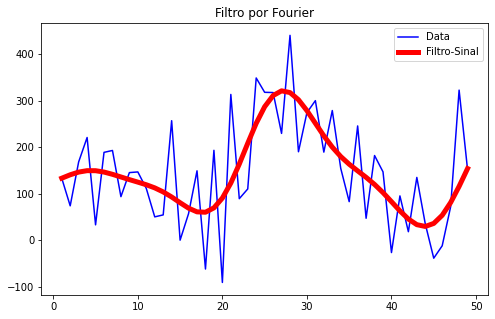

In [75]:
# Filter the data, and plot both the original and filtered signals.
#Após a filtragem dos dados, plot dos dados e do sinal filtrado.
y_filtro = filtfilt(filter_b, filter_a, y)

plt.figure(figsize=[8,5], facecolor='w')
plt.title('Filtro por Fourier')
plt.plot(x, y, 'b-', label='data')
plt.plot(x, y_filtro, 'r-', linewidth=5, label='filtered data')
plt.legend(['Data','Filtro-Sinal'])
plt.show()

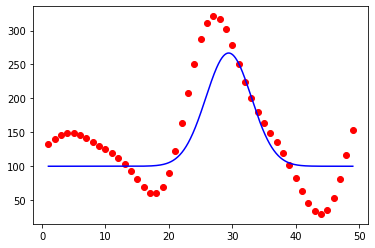

In [81]:
parameters = funcao_ajuste(x,y_filtro, beta_0,beta_1,beta_2,beta_3)

plt.plot(x, y_filtro, 'ro')
plt.plot(x_new, func(x_new, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.show()

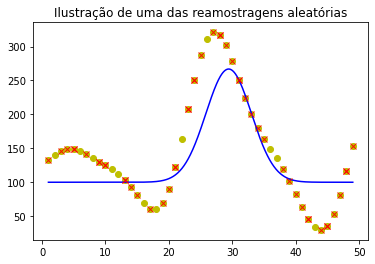

In [77]:
indices = np.arange(len(x))
np.random.shuffle(indices)
mask = np.append(indices[0:37], indices[0:12])
x2 = np.array(x[mask])
y2 = np.array(y_filtro[mask])

plt.title('Ilustração de uma das reamostragens aleatórias')
plt.plot(x, y_filtro, 'yo')
plt.plot(x_new, func(x_new, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.plot(x2,y2,'rx',alpha = 0.9)
plt.show()

In [78]:
indices = np.arange(len(x))
b0 = np.array([])
b1 = np.array([])
b2 = np.array([])
b3 = np.array([])

'''
        Ajustando cada reamostragem e guardando os parametros.
'''

for loop in range(1000): #Junção de 1000 elementos de valores beta relativos a cada reamostragem
    np.random.shuffle(indices)
    mask = np.append(indices[0:37], indices[0:12])
    x2 = np.array(x[mask])
    y2 = np.array(y_filtro[mask])
    parm = funcao_ajuste(x2,y2, parameters[0],parameters[1], parameters[2], parameters[3])
    b0 = np.append(b0,parm[0])
    b1 = np.append(b1,parm[1])
    b2 = np.append(b2,parm[2])
    b3 = np.append(b3,parm[3])


dfb0 = pd.Series(b0)
dfb1 = pd.Series(b1)
dfb2 = pd.Series(b2)
dfb3 = pd.Series(b3)

In [79]:
print('B0: '+str(dfb0.mean())+'+/-'+str(3*dfb0.std()))
print('B1: '+str(dfb1.mean())+'+/-'+str(3*dfb1.std()))
print('B2: '+str(dfb2.mean())+'+/-'+str(3*dfb2.std()))
print('B3: '+str(dfb3.mean())+'+/-'+str(3*dfb3.std()))

B0: 96.83749353557857+/-15.540585531685611
B1: 199.39751072123468+/-13.126584023336783
B2: 27.62829103922087+/-0.21728735617372524
B3: -4.773548684862056+/-0.5019059000520916


Comparado com:
$\beta_0 = 102.24 \pm 37.12$ ; $\beta_1 = 218.80 \pm 107.87$ ; $\beta_2 = 27.91 \pm 1.86$; $\beta_3 = -3.83 \pm 2.43$.

### Alvo 3:

In [82]:
x = df_3['Pixel']
y = df_3['Valor']

In [83]:
## Chutes iniciais
beta_0 = -3
beta_1 = 200
beta_2 = 30
beta_3 = -7

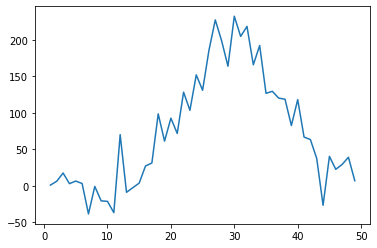

In [84]:
plt.plot(x,y)

In [85]:
parameters = funcao_ajuste(x,y, beta_0,beta_1,beta_2,beta_3)
parameters

(-2.7279528278722864,
 207.18831746759335,
 29.96429401583051,
 -7.301983011256825)

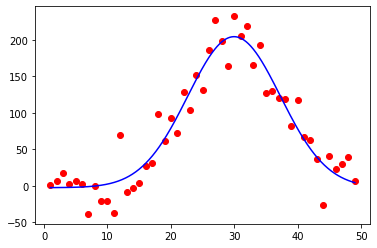

In [86]:
plt.plot(x, y, 'ro')
plt.plot(x_new, func(x_new, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.show()

$\beta_0 = -2.72$ ; $\beta_1 = 207.18$ ; $\beta_2 = 29.96$; $\beta_3 = -7.30 $.

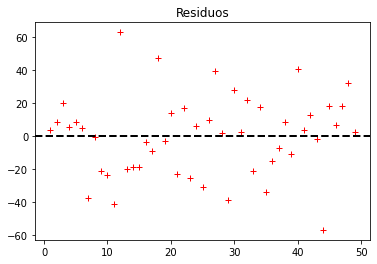

Soma dos quadrados dos residuos: 28318.31280323895


In [87]:
plt.title('Residuos')
plt.plot(x, y - func(x, parameters[0], parameters[1], parameters[2], parameters[3]) , 'r+')
plt.axhline(0, color='k', ls='--', lw=2)
plt.show()

print('Soma dos quadrados dos residuos:', residuo_quadrado(data=y, modelo=
                                                           func(x, parameters[0], parameters[1], 
                                                                parameters[2], parameters[3])))

### Método Bootstrap
Definindo os intervalos de confiança para $\beta$.

In [88]:
indices = np.arange(len(x))
np.random.shuffle(indices)
mask = np.append(indices[0:37], indices[0:12])
x2 = np.array(x[mask])
y2 = np.array(y[mask])

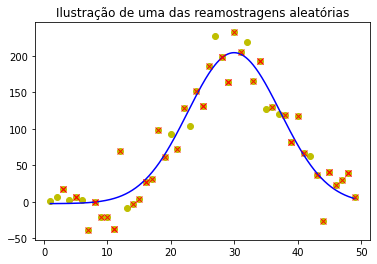

In [89]:
plt.title('Ilustração de uma das reamostragens aleatórias')
plt.plot(x, y, 'yo')
plt.plot(x_new, func(x_new, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.plot(x2,y2,'rx',alpha = 0.9)
plt.show()

In [90]:
indices = np.arange(len(x))
b0 = np.array([])
b1 = np.array([])
b2 = np.array([])
b3 = np.array([])

'''
        Ajustando cada reamostragem e guardando os parametros.
'''

for loop in range(1000): #Junção de 1000 elementos de valores beta relativos a cada reamostragem
    np.random.shuffle(indices)
    mask = np.append(indices[0:37], indices[0:12])
    x2 = np.array(x[mask])
    y2 = np.array(y[mask])
    parm = funcao_ajuste(x2,y2, parameters[0],parameters[1], parameters[2], parameters[3])
    b0 = np.append(b0,parm[0])
    b1 = np.append(b1,parm[1])
    b2 = np.append(b2,parm[2])
    b3 = np.append(b3,parm[3])

In [91]:
dfb0 = pd.Series(b0)
dfb1 = pd.Series(b1)
dfb2 = pd.Series(b2)
dfb3 = pd.Series(b3)

B0: -2.9666478662455016+/-13.5828537951556


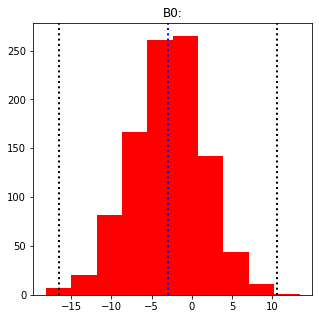

In [92]:
plt.figure(figsize = [5,5])
plt.title('B0:')
plt.hist(b0,bins=10,color='r')
plt.axvline(dfb0.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb0.std()*3 + dfb0.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb0.std()*3 + dfb0.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B0: '+str(dfb0.mean())+'+/-'+str(3*dfb0.std()))
plt.show()

B1: 207.53110253599692+/-21.783256338785073


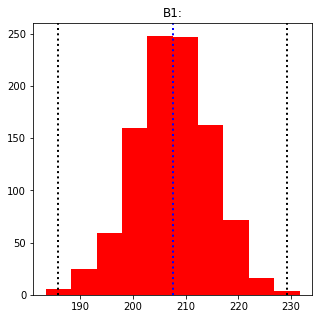

In [93]:
plt.figure(figsize = [5,5])
plt.title('B1:')
plt.hist(b1,bins=10,color='r')
plt.axvline(dfb1.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb1.std()*3 + dfb1.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb1.std()*3 + dfb1.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B1: '+str(dfb1.mean())+'+/-'+str(3*dfb1.std()))
plt.show()

B2: 29.975781694037877+/-0.6802530175244531


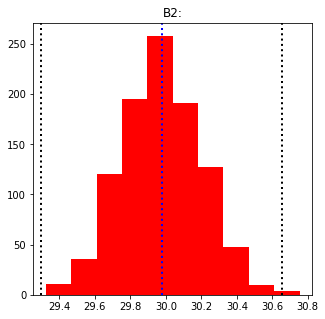

In [94]:
plt.figure(figsize = [5,5])
plt.title('B2:')
plt.hist(b2,bins=10,color='r')
plt.axvline(dfb2.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb2.std()*3 + dfb2.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb2.std()*3 + dfb2.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B2: '+str(dfb2.mean())+'+/-'+str(3*dfb2.std()))
plt.show()

B3: -7.295536021012774+/-0.9575128302875935


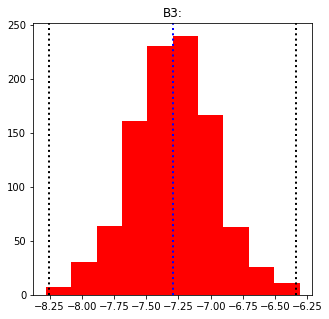

In [95]:
plt.figure(figsize = [5,5])
plt.title('B3:')
plt.hist(b3,bins=10,color='r')
plt.axvline(dfb3.mean(), color='b', linestyle='dotted', linewidth=2) 
plt.axvline(dfb3.std()*3 + dfb3.mean(), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-dfb3.std()*3 + dfb3.mean(), color='k', linestyle='dotted', linewidth=2) 
print('B3: '+str(dfb3.mean())+'+/-'+str(3*dfb3.std()))
plt.show()

$\beta_0 = -2.95 \pm 14.13$ ; $\beta_1 = 207.40 \pm 22.30$ ; $\beta_2 = 29.98 \pm 0.71$; $\beta_3 = -7.30 \pm 1.00$.

In [96]:
parm = b0,b1,b2,b3
print('Matriz das variancias e covariancias entre os parâmetros.')
pd.DataFrame(matrix_var_cov(parm),columns=['Beta0','Beta1','Beta2','Beta3'])

Matriz das variancias e covariancias entre os parâmetros.


,Beta0,Beta1,Beta2,Beta3
0,20.499324,-15.308093,-0.015675,0.846440
1,-15.308093,52.723362,-0.117701,0.434764
2,-0.015675,-0.117701,0.051416,-0.001525
3,0.846440,0.434764,-0.001525,0.101870


In [97]:
y_modelo = func(x, parameters[0], parameters[1], parameters[2], parameters[3])
residuo = pd.Series(y - y_modelo)
residuo.describe()

count    49.000000
mean     -0.096112
std      24.288998
min     -56.815989
25%     -19.062767
50%       2.600049
75%      13.698923
max      62.694222
dtype: float64

#### Filtrando os dados:

Mesmo método usado em **Alvo1** e **Alvo2**, por transformada de Fourier.

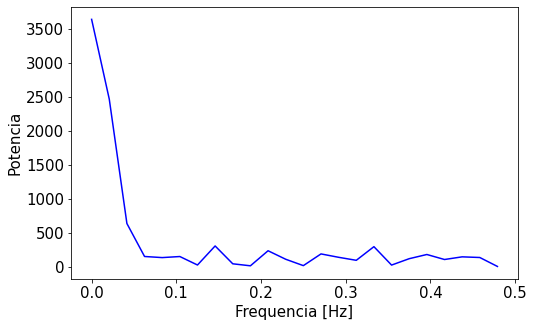

In [98]:
# Transformada de Fourier:
y = np.array(y)
x = np.array(x)

N = len(x) # Numero de pontos
T = (x[-1] - x[0])/len(x) # resolução dos pontos

# Aplicando a transformada de Fourier
yf = fft(y)[:int(N/2)]
xf = fftfreq(N, T)[:int(N/2)]

plt.figure(figsize=[8,5], facecolor='w')
plt.plot(xf, np.absolute(yf), color='blue')
plt.ylabel('Potencia', fontsize=15)
plt.xlabel('Frequencia [Hz]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [99]:
ordem = 10
corte = 0.1

filter_b, filter_a = butter(N=ordem, Wn=corte, fs=1/T, btype='lowpass')
# Transformando o filtro em resposta de frequência
w, h = freqz(filter_b, filter_a, fs=1/T, worN=8000)

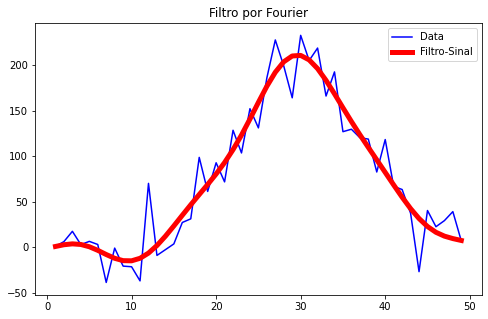

In [100]:
# Filter the data, and plot both the original and filtered signals.
#Após a filtragem dos dados, plot dos dados e do sinal filtrado.
y_filtro = filtfilt(filter_b, filter_a, y)

plt.figure(figsize=[8,5], facecolor='w')
plt.title('Filtro por Fourier')
plt.plot(x, y, 'b-', label='data')
plt.plot(x, y_filtro, 'r-', linewidth=5, label='filtered data')
plt.legend(['Data','Filtro-Sinal'])
plt.show()

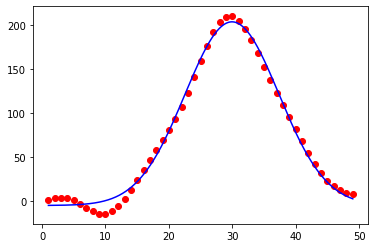

In [101]:
parameters = funcao_ajuste(x,y_filtro, beta_0,beta_1,beta_2,beta_3)

plt.plot(x, y_filtro, 'ro')
plt.plot(x_new, func(x_new, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.show()

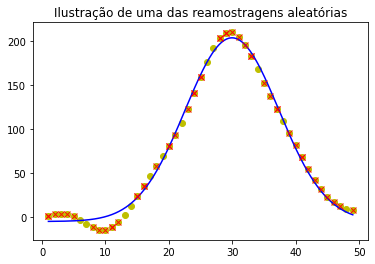

In [102]:
indices = np.arange(len(x))
np.random.shuffle(indices)
mask = np.append(indices[0:37], indices[0:12])
x2 = np.array(x[mask])
y2 = np.array(y_filtro[mask])

plt.title('Ilustração de uma das reamostragens aleatórias')
plt.plot(x, y_filtro, 'yo')
plt.plot(x_new, func(x_new, parameters[0], parameters[1], parameters[2], parameters[3]) , 'b-')
plt.plot(x2,y2,'rx',alpha = 0.9)
plt.show()

In [103]:
indices = np.arange(len(x))
b0 = np.array([])
b1 = np.array([])
b2 = np.array([])
b3 = np.array([])

'''
        Ajustando cada reamostragem e guardando os parametros.
'''

for loop in range(1000): #Junção de 1000 elementos de valores beta relativos a cada reamostragem
    np.random.shuffle(indices)
    mask = np.append(indices[0:37], indices[0:12])
    x2 = np.array(x[mask])
    y2 = np.array(y_filtro[mask])
    parm = funcao_ajuste(x2,y2, parameters[0],parameters[1], parameters[2], parameters[3])
    b0 = np.append(b0,parm[0])
    b1 = np.append(b1,parm[1])
    b2 = np.append(b2,parm[2])
    b3 = np.append(b3,parm[3])


dfb0 = pd.Series(b0)
dfb1 = pd.Series(b1)
dfb2 = pd.Series(b2)
dfb3 = pd.Series(b3)

In [104]:
print('B0: '+str(dfb0.mean())+'+/-'+str(3*dfb0.std()))
print('B1: '+str(dfb1.mean())+'+/-'+str(3*dfb1.std()))
print('B2: '+str(dfb2.mean())+'+/-'+str(3*dfb2.std()))
print('B3: '+str(dfb3.mean())+'+/-'+str(3*dfb3.std()))

B0: -5.631399138905643+/-5.205668403598604
B1: 209.85790798775048+/-5.995852434306786
B2: 29.96407087641152+/-0.14921837450626493
B3: -7.392232878083771+/-0.2631700907398399


Comparado com:
$\beta_0 = -2.95 \pm 14.13$ ; $\beta_1 = 207.40 \pm 22.30$ ; $\beta_2 = 29.98 \pm 0.71$; $\beta_3 = -7.30 \pm 1.00$.

#### Alvo1: soma do quadrado dos residuos = 164.647,36
#### $\beta_1 = 594,92 \pm 53,56$ -> Mais brilhante
#### Variancias: $V(\beta_0) = 74,84$ ; $V(\beta_1) = 318,72$; $V(\beta_2) = 0,02$; $V(\beta_3) = 0,02$
#### Alvo2: soma do quadrado dos residuos = 422.664,78
$\beta_1 = 219,80 \pm 107,90$
#### Variancias: $V(\beta_0) = 153,12$ ; $V(\beta_1) = 1293,03$; $V(\beta_2) = 0,38$; $V(\beta_3) = 0,66$
#### Alvo3: soma do quadrado dos residuos = 28.318,31 -> Melhor qualidade
$\beta_1 = 207,40 \pm 22,30$
#### Variancias: $V(\beta_0) = 22,17$ ; $V(\beta_1) = 55,23$; $V(\beta_2) = 0,06$; $V(\beta_3) = 0,11$

>Embora o alvo 1 tenha variancias menores nos parâmetros $\beta_2$ e $\beta_3$, no geral as variancias no alvo 3 são bem menores.